## In this topic, we present about the measures for anomaly detection if we use method unsupervised outlier detection. We know that unsupervised outlier detection using  data without label. We will show one methods for it which em mv mehods. the first step we install pyod and  and emmv library with command pip install pyod and pip install emmv

> ! pip install pyod 

>  ! pip install emmv block

>  !pip list -v for know list of packages in colab




In [ ]:
!pip install emmv

In [ ]:
!pip install pyod

In [ ]:
!pip install adtk

In [ ]:
!pip install combo

In [ ]:
import numpy as np
from pyod.models.copod import COPOD

from emmv import emmv_scores

rng = np.random.RandomState(42)

NUM_COLS = 7
# Generate train data
X = 0.3 * rng.randn(100, NUM_COLS)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, NUM_COLS)
X_regular = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, NUM_COLS))
# fit the model
model = COPOD()
model.fit(X_train)

# Get EM & MV scores
X_test = np.concatenate((X_regular, X_outliers), axis=0)
test_scores = emmv_scores(model, X_test)
print('Excess Mass score;', test_scores['em'])
print('Mass Volume score:', test_scores['mv'])

Excess Mass score; 0.0072596801
Mass Volume score: 1067810.6455843074


In [ ]:
import pandas as pd
import numpy as np
from adtk.data import validate_series
from adtk.detector import GeneralizedESDTestAD

from emmv import emmv_scores

rng = np.random.RandomState(42)

# Generate train data
timestamps = pd.date_range("2018-01-01", periods=200, freq="H")
X = 0.3 * rng.randn(100)
values = np.r_[X + 2, X - 2]
data = pd.Series(values, index=timestamps)
X_train = validate_series(data)

# Generate some regular novel observations
X = 0.3 * rng.randn(67)
X_regular = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(66))
# Create test data
timestamps = pd.date_range("2018-01-01", periods=200, freq="H")
values = np.concatenate((X_regular, X_outliers), axis=0)
data = pd.Series(values, index=timestamps)
X_test = validate_series(data)

# Fit model
model = GeneralizedESDTestAD()
anomalies = model.fit_detect(X_train)

# Get EM & MV scores

# TF models do not have a "decision_function" method, so we need to specify
# our own custom anomaly scoring function. This one is specific to GeneralizedESDTestAD.
# It is adapted from: https://github.com/odnura/adtk/blob/73bfb30ba457dd540e8aea82782431254da480ce/src/adtk/detector/_detector_1d.py#L346
def scoring_function(model, df):
    s = pd.Series(df) # 1D data expected
    new_sum = s + model._normal_sum
    new_count = model._normal_count + 1
    new_mean = new_sum / new_count
    new_squared_sum = s ** 2 + model._normal_squared_sum
    new_std = np.sqrt(
        (
            new_squared_sum
            - 2 * new_mean * new_sum
            + new_count * new_mean ** 2
        )
        / (new_count - 1)
    )
    anomaly_scores = (s - new_mean).abs() / new_std
    return anomaly_scores

test_scores = emmv_scores(model, X_test, scoring_function)
print('Excess Mass score;', test_scores['em'])
print('Mass Volume score:', test_scores['mv'])

Excess Mass score; 0.006291853399999999
Mass Volume score: 6.5658257289213795


In [ ]:
'''
Author: Christian O'Leary
Email: cjjoleary@gmail.com
'''

import os
import random

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.models import Sequential

from emmv import emmv_scores

seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
rng = np.random.RandomState(seed)
tf.random.set_seed(seed)
NUM_COLS = 1

# Generate train data
X = 0.3 * rng.randn(100, NUM_COLS)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, NUM_COLS)
X_regular = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, NUM_COLS))
X_test = np.concatenate((X_regular, X_outliers), axis=0)

# fit the model
model = Sequential([
            InputLayer(input_shape=NUM_COLS),
            Dense(32),
            Dense(NUM_COLS, activation='relu')
        ])
model.compile(loss='mse', optimizer='adam')
model.fit(
    X_train,
    X_train, # i.e. reconstruction model
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    verbose=1
)

# Get EM & MV scores

# TF models do not have a "decision_function" method, so we need to specify
# our own custom anomaly scoring function. This one uses MAPE.
def scoring_function(model, df):
    offset = 0.00000001 # to prevent division by 0
    # 1. model predictions
    preds = model.predict(df)
    # 2. Use a regression metric, e.g. MAPE
    anomaly_scores = np.mean((np.abs(preds - df) / (df + offset)), axis=1) # i.e. anomaly score
    return anomaly_scores

test_scores = emmv_scores(model, X_test, scoring_function)
print('Excess Mass score;', test_scores['em'])
print('Mass Volume score:', test_scores['mv'])

In [ ]:
'''
Author: Christian O'Leary
Email: cjjoleary@gmail.com
'''

from emmv import emmv_scores

# Adapted from https://pycaret.org/setup/
# Importing dataset
from pycaret.datasets import get_data
anomalies = get_data('anomaly')

# Importing module and initializing setup
from pycaret.anomaly import *
anomaly_setup = setup(data=anomalies)

# create a model
model = create_model('iforest')
results = assign_model(model)

# Get EM & MV scores
test_scores = emmv_scores(model, anomalies)
print('Excess Mass score;', test_scores['em'])
print('Mass Volume score:', test_scores['mv'])


On Training Data:
Aggregation by Averaging ROC:0.9994, precision @ rank n:0.95

On Test Data:
Aggregation by Averaging ROC:1.0, precision @ rank n:1.0


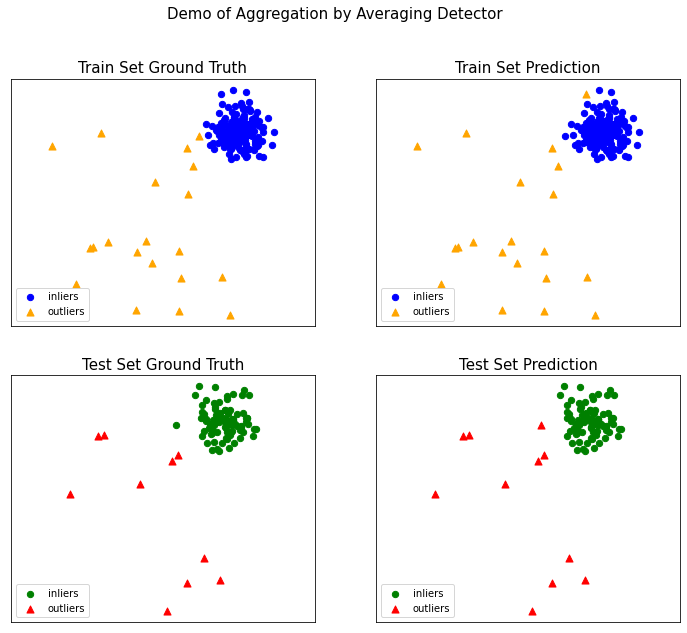

In [ ]:
# -*- coding: utf-8 -*-
"""Example of using simple aggregation for outlier detection
"""
# Author: Yue Zhao <zhaoy@cmu.edu>
# License: BSD 2 clause

import os
import sys

# temporary solution for relative imports in case combo is not installed
# if combo is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

# supress warnings for clean output
import warnings

warnings.filterwarnings("ignore")

from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

from combo.models.detector_comb import SimpleDetectorAggregator

contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points

# Generate sample data
X_train, y_train, X_test, y_test = \
    generate_data(n_train=n_train,
                  n_test=n_test,
                  n_features=2,
                  contamination=contamination,
                  random_state=42)

detectors = [KNN(), LOF(), OCSVM()]

clf = SimpleDetectorAggregator(base_estimators=detectors)
clf_name = 'Aggregation by Averaging'
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# visualize the results
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=True)